In [9]:
import pyBeamSim
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
from tqdm import tqdm, trange

In [ ]:
simulator = pyBeamSim.BeamSimulator()
# simulator.free_beam()
simulator.init_beam(102400, 939.294, 1.0, 0.015)
simulator.beam_init_from_file('CLAPA_beam.beam')
simulator.beam_print_to_file("./beam_file/temp_beam1")
beam_data = np.loadtxt("./beam_file/temp_beam1")

Text(0, 0.5, 'Count')

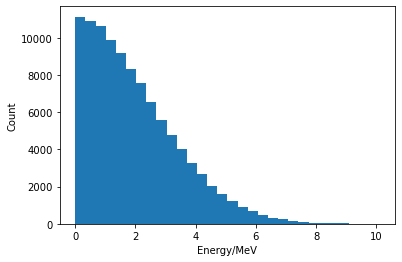

In [18]:
plt.hist(beam_data[:,-3], bins=30)
plt.xlabel("Energy/MeV")
plt.ylabel("Count")

# 收集角度50mrad

In [9]:
simulator.free_beam()

0.010968923568725586 s
0.015636205673217773 s


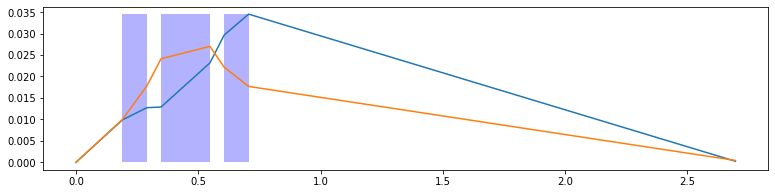

In [3]:
num_particle = 10240

simulator = pyBeamSim.BeamSimulator()
# simulator.free_beam()
simulator.init_beam(num_particle, 939.294, 1.0, 0.015)
start = time.time()
simulator.set_beamTwiss(0, 0.01, 0.00003,0, 0.01, 0.00003,0, 6.5430429, 0.0000005, 0, 4.622, 500, 1)
simulator.save_initial_beam()
# simulator.plot_beam()
# simulator.beam_print_to_file("./beam_file/init_beam")
print(time.time()-start ,'s')
simulator.load_Beamline_From_DatFile("F:/git_workspace/Multi-Particle-BeamLine-Simulation/Main_for_simulation/clapa1.dat")
element_names = simulator.get_Beamline_ElementNames()
start = time.time()

simulator.set_magnet_with_name("Q1", 13.1313463)
simulator.set_magnet_with_name("Q2", -10.4256375)
simulator.set_magnet_with_name("Q3", 12.12751015)

envelope = simulator.simulate_and_getEnvelope(False, False)
print(time.time()-start, 's')
simulator.plot_envelope(envelope)

In [7]:
simulator.get_good_num()

10240

Text(0, 0.5, 'Count')

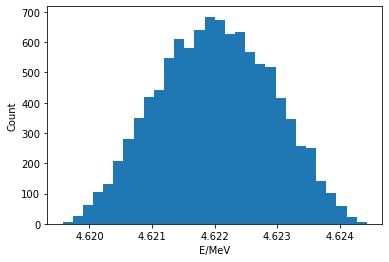

In [23]:
simulator.beam_print_to_file("./beam_file/init_beam")
init_beam = np.loadtxt('./beam_file/init_beam')
plt.hist(init_beam[:,5], bins=30)
plt.xlabel("E/MeV")
plt.ylabel("Count")

# 1. 贝叶斯优化取得最小聚焦

In [48]:
def modify_parameters_and_simulate(G1, G2, G3):
    simulator.set_magnet_with_name("Q1", G1)
    simulator.set_magnet_with_name("Q2", G2)
    simulator.set_magnet_with_name("Q3", G3)
#     simulator.set_beamTwiss(0, 0.01, 0.000015,0, 0.01, 0.000015,0, 6.5430429, 0.0005633529, 0, 3, 500, 1)
    simulator.restore_initial_beam()
    envelope = simulator.simulate_and_getEnvelope(False, False)
    return envelope

num_particle = 10240

envelope_animation = []
min_loss = 10000
min_loss_list = []
beam_filename_list = []

def obj(args):
    global min_loss
    global envelope_animation
    global beam_filename_list
    global min_loss_list
    G1, G2, G3 = args
    envelope = modify_parameters_and_simulate(G1, G2, G3)
    
    sig_x = envelope[-1, 1]
    sig_y = envelope[-1, 2]
#     loss_ratio = envelope[-1, 3]/num_particle
    
    ans = sig_y**2 + sig_x**2 + (sig_x - sig_y)**2
    
    if min_loss > ans:
        min_loss = ans
        min_loss_list.append(ans)
#         envelope_animation.append(envelope)
#         filename = "./beam_file/step_%d"%(len(beam_filename_list))
#         simulator.beam_print_to_file(filename)
#         beam_filename_list.append(filename)
    else:
        min_loss_list.append(min_loss)
#         envelope_animation.append(envelope_animation[-1])
#         beam_filename_list.append(beam_filename_list[-1])
    return {'loss':ans, 'status': STATUS_OK}

100%|████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.90trial/s, best loss: 3.1715211146380203e-07]
{'G1': 13.131346300020367, 'G2': -10.425637540363962, 'G3': 12.127510150741767}


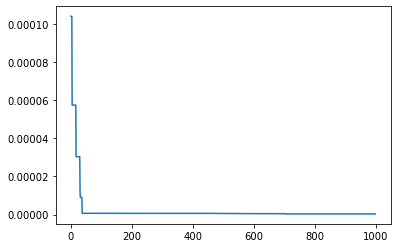

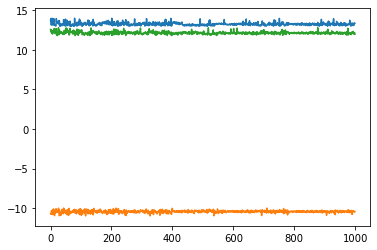

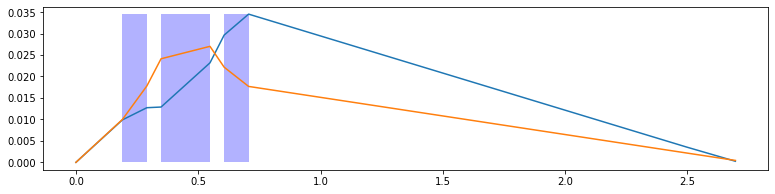

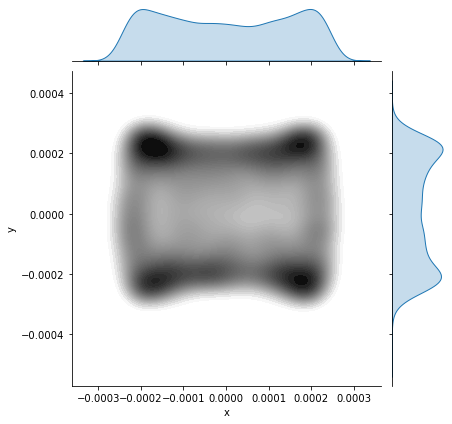

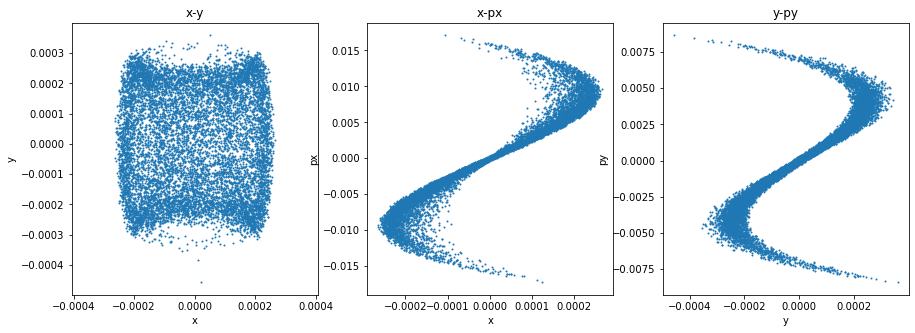

In [49]:
envelope_animation = []
beam_filename_list = []
min_loss_list = []
min_loss = 10000
G_trials = Trials()
best_G = fmin(
    fn=obj,
    space=[hp.uniform('G1', 13, 14), hp.uniform('G2', -11, -10), hp.uniform('G3', 11.8, 12.8)],
    algo=tpe.suggest,
    max_evals=1000,
    trials = G_trials)

print(best_G)
# plt.plot(G_trials.losses())
plt.plot(min_loss_list)

vals = [item['misc']['vals'] for item in G_trials.trials]
G1_list = [item['G1'][0] for item in vals]
G2_list = [item['G2'][0] for item in vals]
G3_list = [item['G3'][0] for item in vals]

plt.figure()
plt.plot(G1_list)
plt.plot(G2_list)
plt.plot(G3_list)
plt.show()

envelope = modify_parameters_and_simulate(best_G['G1'], best_G['G2'], best_G['G3'])
simulator.plot_envelope(envelope)
simulator.plot_beam()

element_types = simulator.get_Beamline_ElementTypes()
element_lengths = simulator.get_Beamline_ElementLengths()
position_start = np.array([])
position_end = np.array([])
for i in range(element_lengths.shape[0]):
    position_start = np.append(position_start, element_lengths[:i].sum())
    position_end = np.append(position_end, position_start[i] + element_lengths[i])

# 2. 生成数据

# 设置基准：
* delta_G1 = 0.0
* delta_G2 = 0.0
* delta_G3 = 0.0
* sigma_x = 0.00015211627606514619
* sigma_y = 0.00017469935691262625
* max_x = 0.00026572236704425423
* max_y = 0.0004578556021766969
* good_number = 10240.0

In [31]:
import pandas as pd
from tqdm import tqdm, trange

def deltaG_and_simulate(delta_G1, delta_G2, delta_G3):
    global data_log
    simulator.set_magnet_with_name("Q1", 13.1313463+delta_G1)
    simulator.set_magnet_with_name("Q2", -10.4256375+delta_G2)
    simulator.set_magnet_with_name("Q3", 12.12751015+delta_G3)
#     simulator.set_beamTwiss(0, 0.01, 0.000015,0, 0.01, 0.000015,0, 6.5430429, 0.0005633529, 0, 3, 500, 1)
    simulator.restore_initial_beam()
#     envelope = simulator.simulate_all(False, False)
    simulator.simulate_all(False, False)
    delta_sigma_x = simulator.getBeamSigx()
    delta_sigma_y = simulator.getBeamSigy()
    delta_max_x = simulator.getBeamMaxx()
    delta_max_y = simulator.getBeamMaxy()
    delta_good_num = simulator.get_good_num()
    data_log.loc[len(data_log)] = [13.1313463+delta_G1, -10.4256375+delta_G2, 12.12751015+delta_G3, delta_sigma_x, delta_sigma_y, delta_max_x, delta_max_y, delta_good_num]

In [32]:
data_log = pd.DataFrame(columns=["G1", "G2", "G3", "sigma_x", "sigma_y", "max_x", "max_y", "good_number"])
deltaG_and_simulate(0, 0, 0)
data_log

,G1,G2,G3,sigma_x,sigma_y,max_x,max_y,good_number
0,13.131346,-10.425638,12.12751,0.000152,0.000175,0.000266,0.000458,10240.0


# 同时随机调整3个磁铁

In [160]:
data_log = pd.DataFrame(columns=["G1", "G2", "G3", "sigma_x", "sigma_y", "max_x", "max_y", "good_number"])

rand_delta_G = (np.random.rand(500,3) - 0.5)
for i in trange(len(rand_delta_G)):
    deltaG_and_simulate(rand_delta_G[i,0], rand_delta_G[i,1], rand_delta_G[i,2])

data_log.to_csv("./期末大作业/调整3块磁铁.csv")

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 251.58it/s]


In [11]:
data_log = pd.read_csv("./期末大作业/调整3块磁铁.csv", index_col="Unnamed: 0")
data_log

,G1,G2,G3,sigma_x,sigma_y,max_x,max_y,good_number
0,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0
1,12.932603,-10.425393,12.320510,0.001431,0.000332,0.003326,0.001699,10240.0
2,12.699503,-10.087524,12.499693,0.003860,0.008192,0.009883,0.023121,10240.0
3,13.064150,-10.777704,11.849927,0.003442,0.009361,0.009813,0.024651,10240.0
4,13.544687,-10.228019,12.331367,0.002738,0.006414,0.006941,0.018363,10240.0
...,...,...,...,...,...,...,...,...
495,13.424120,-10.437393,11.692254,0.002862,0.001860,0.008161,0.004187,10240.0
496,13.082035,-10.824425,12.563826,0.001963,0.007046,0.004715,0.018329,10240.0
497,12.706278,-10.883317,12.427526,0.000356,0.009829,0.000609,0.025947,10240.0
498,12.709517,-10.573271,12.612198,0.002970,0.002128,0.007415,0.004970,10240.0


In [12]:
delta_log = pd.DataFrame(columns=["G1", "G2", "G3", "sigma_x", "sigma_y", "max_x", "max_y", "good_number", "delta_G1", "delta_G2", "delta_G3", "delta_sigma_x", "delta_sigma_y", "delta_max_x", "delta_max_y", "delta_good_number"])
for i in trange(1, len(data_log)):
    for j in range(i):
        delta_log.loc[len(delta_log)] = np.append(data_log.loc[j].values, data_log.loc[i].values - data_log.loc[j].values)
delta_log_all = delta_log
delta_log.head(10)

100%|█████████████████████████████████████████████████████| 499/499 [09:08<00:00,  1.10s/it]


,G1,G2,G3,sigma_x,sigma_y,max_x,max_y,good_number,delta_G1,delta_G2,delta_G3,delta_sigma_x,delta_sigma_y,delta_max_x,delta_max_y,delta_good_number
0,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0,0.168567,-0.469236,0.115810,-0.000730,-0.009460,-0.002015,-0.025778,0.0
1,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0,-0.064533,-0.131367,0.294993,0.001698,-0.001600,0.004542,-0.004357,0.0
2,12.932603,-10.425393,12.320510,0.001431,0.000332,0.003326,0.001699,10240.0,-0.233100,0.337869,0.179183,0.002428,0.007860,0.006557,0.021422,0.0
3,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0,0.300114,-0.821547,-0.354773,0.001280,-0.000431,0.004473,-0.002827,0.0
4,12.932603,-10.425393,12.320510,0.001431,0.000332,0.003326,0.001699,10240.0,0.131547,-0.352311,-0.470584,0.002011,0.009028,0.006487,0.022952,0.0
5,12.699503,-10.087524,12.499693,0.003860,0.008192,0.009883,0.023121,10240.0,0.364647,-0.690180,-0.649767,-0.000418,0.001169,-0.000070,0.001530,0.0
6,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0,0.780651,-0.271862,0.126667,0.000576,-0.003378,0.001601,-0.009115,0.0
7,12.932603,-10.425393,12.320510,0.001431,0.000332,0.003326,0.001699,10240.0,0.612084,0.197374,0.010857,0.001306,0.006082,0.003615,0.016663,0.0
8,12.699503,-10.087524,12.499693,0.003860,0.008192,0.009883,0.023121,10240.0,0.845184,-0.140495,-0.168326,-0.001122,-0.001778,-0.002941,-0.004758,0.0
9,13.064150,-10.777704,11.849927,0.003442,0.009361,0.009813,0.024651,10240.0,0.480537,0.549686,0.481441,-0.000704,-0.002947,-0.002872,-0.006288,0.0


In [15]:
delta_log_all['sig_ratio'] = delta_log_all['sigma_x'].values/delta_log_all['sigma_y'].values
delta_log_all.corr().iloc[-1:, :3]

,G1,G2,G3
sig_ratio,-0.007881,0.001401,0.056181


          delta_sigma_x  delta_sigma_y  delta_max_x  delta_max_y  \
delta_G1      -0.155417       0.033735    -0.161020     0.037862   
delta_G2      -0.025244      -0.065973    -0.064804     0.006619   
delta_G3       0.033300      -0.072068    -0.072808    -0.061602   

          delta_good_number  
delta_G1                NaN  
delta_G2                NaN  
delta_G3                NaN  


<AxesSubplot:>

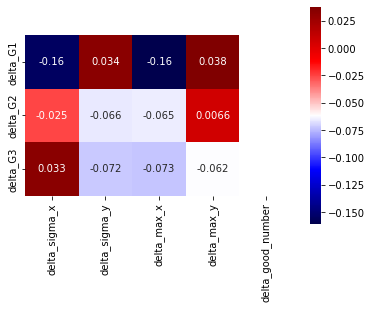

In [125]:
corr_map = delta_log_all.corr().iloc[:3, 3:]
print(corr_map)
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)

# 只调整一块磁铁

## Q1:

In [126]:
data_log = pd.DataFrame(columns=["G1", "G2", "G3", "sigma_x", "sigma_y", "max_x", "max_y", "good_number"])

rand_delta_G = (np.random.rand(500) - 0.5)
for i in trange(len(rand_delta_G)):
    deltaG_and_simulate(rand_delta_G[i], 0, 0)

data_log.to_csv("./期末大作业/只调整Q1.csv")

delta_log = pd.DataFrame(columns=["delta_G1", "delta_G2", "delta_G3", "delta_sigma_x", "delta_sigma_y", "delta_max_x", "delta_max_y", "delta_good_number"])
for i in trange(1, len(data_log)):
    for j in range(i):
        delta_log.loc[len(delta_log)] = data_log.loc[i].values - data_log.loc[j].values
delta_log_Q1 = delta_log
delta_log.head(10)

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [06:11<00:00,  1.34it/s]


,delta_G1,delta_G2,delta_G3,delta_sigma_x,delta_sigma_y,delta_max_x,delta_max_y,delta_good_number
0,0.695958,0.0,0.0,0.000059,-0.000829,-0.000714,-0.000623,0.0
1,0.701904,0.0,0.0,0.000064,-0.000815,-0.000702,-0.000582,0.0
2,0.005946,0.0,0.0,0.000006,0.000014,0.000011,0.000041,0.0
3,0.690695,0.0,0.0,0.000054,-0.000842,-0.000724,-0.000659,0.0
4,-0.005263,0.0,0.0,-0.000005,-0.000013,-0.000010,-0.000036,0.0
5,-0.011209,0.0,0.0,-0.000011,-0.000027,-0.000022,-0.000077,0.0
6,0.829912,0.0,0.0,0.000185,-0.000501,-0.000439,0.000299,0.0
7,0.133954,0.0,0.0,0.000126,0.000329,0.000275,0.000922,0.0
8,0.128008,0.0,0.0,0.000121,0.000314,0.000263,0.000881,0.0
9,0.139217,0.0,0.0,0.000131,0.000341,0.000285,0.000958,0.0


               delta_G1  delta_sigma_x  delta_sigma_y  delta_max_x  \
delta_G1       1.000000       0.698622      -0.358089    -0.227650   
delta_sigma_x  0.698622       1.000000       0.343084     0.504158   
delta_sigma_y -0.358089       0.343084       1.000000     0.969503   
delta_max_x   -0.227650       0.504158       0.969503     1.000000   
delta_max_y    0.359866       0.894053       0.717340     0.824727   

               delta_max_y  
delta_G1          0.359866  
delta_sigma_x     0.894053  
delta_sigma_y     0.717340  
delta_max_x       0.824727  
delta_max_y       1.000000  


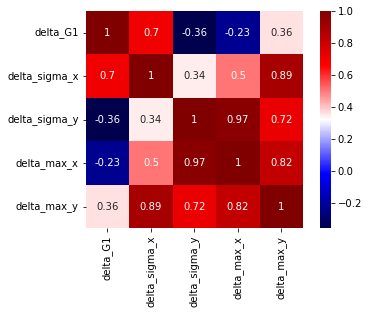

          delta_sigma_x  delta_sigma_y  delta_max_x  delta_max_y
delta_G1       0.698622      -0.358089     -0.22765     0.359866


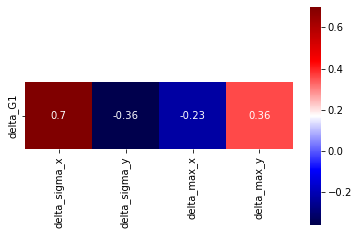

In [127]:
corr_map = delta_log_Q1.corr().iloc[[0,3,4,5,6],[0,3,4,5,6]]
print(corr_map)
plt.figure()
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)
plt.show()

corr_map = delta_log_Q1.corr().iloc[:1,[3,4,5,6]]
print(corr_map)
plt.figure()
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)
plt.show()

(array([  107.,   129.,   141.,   147.,   184.,   204.,   235.,   323.,
          430.,   617.,   824.,  1304.,  2081.,  4399., 10602., 23622.,
        59382.,  7470.,  3441.,  1797.,  1074.,   795.,   534.,   406.,
          336.,   262.,   201.,   178.,   140.,   125.]),
 array([-4.99562859e+00, -4.66245176e+00, -4.32927493e+00, -3.99609811e+00,
        -3.66292128e+00, -3.32974445e+00, -2.99656763e+00, -2.66339080e+00,
        -2.33021397e+00, -1.99703715e+00, -1.66386032e+00, -1.33068349e+00,
        -9.97506666e-01, -6.64329839e-01, -3.31153013e-01,  2.02381373e-03,
         3.35200640e-01,  6.68377467e-01,  1.00155429e+00,  1.33473112e+00,
         1.66790795e+00,  2.00108477e+00,  2.33426160e+00,  2.66743843e+00,
         3.00061525e+00,  3.33379208e+00,  3.66696891e+00,  4.00014573e+00,
         4.33332256e+00,  4.66649939e+00,  4.99967621e+00]),
 <BarContainer object of 30 artists>)

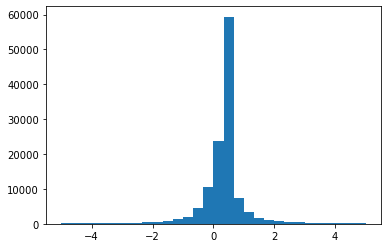

In [91]:
# x y 长宽比变化
xy_ratio = delta_log_Q1['delta_sigma_x'].values/delta_log_Q1['delta_sigma_y'].values
xy_ratio = xy_ratio[(xy_ratio>-5) & (xy_ratio<5)]
plt.hist(xy_ratio, bins=30)

## Q2:

In [51]:
data_log = pd.DataFrame(columns=["G1", "G2", "G3", "sigma_x", "sigma_y", "max_x", "max_y", "good_number"])

rand_delta_G = (np.random.rand(500) - 0.5)*2
for i in trange(len(rand_delta_G)):
    deltaG_and_simulate(0, rand_delta_G[i], 0)

data_log.to_csv("./期末大作业/只调整Q2.csv")

delta_log = pd.DataFrame(columns=["delta_G1", "delta_G2", "delta_G3", "delta_sigma_x", "delta_sigma_y", "delta_max_x", "delta_max_y", "delta_good_number"])
for i in trange(1, len(data_log)):
    for j in range(i):
        delta_log.loc[len(delta_log)] = data_log.loc[i].values - data_log.loc[j].values
delta_log_Q2 = delta_log
delta_log.head(10)

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [06:17<00:00,  1.32it/s]


,delta_G1,delta_G2,delta_G3,delta_sigma_x,delta_sigma_y,delta_max_x,delta_max_y,delta_good_number
0,0.0,-0.994132,0.0,0.003562,0.021178,0.010352,0.049406,-92.0
1,0.0,0.924685,0.0,0.003419,0.020406,0.008953,0.049427,-53.0
2,0.0,1.918817,0.0,-0.000142,-0.000772,-0.001399,0.000021,39.0
3,0.0,-0.769873,0.0,0.002667,0.016833,0.007934,0.044831,0.0
4,0.0,0.224258,0.0,-0.000895,-0.004344,-0.002418,-0.004575,92.0
5,0.0,-1.694559,0.0,-0.000753,-0.003572,-0.001019,-0.004596,53.0
6,0.0,-0.413926,0.0,0.001282,0.009097,0.004150,0.023768,0.0
7,0.0,0.580205,0.0,-0.002280,-0.012080,-0.006202,-0.025638,92.0
8,0.0,-1.338611,0.0,-0.002137,-0.011308,-0.004803,-0.025659,53.0
9,0.0,0.355947,0.0,-0.001385,-0.007736,-0.003784,-0.021063,0.0


               delta_G2  delta_sigma_x  delta_sigma_y  delta_max_x  \
delta_G2       1.000000       0.061791      -0.002956    -0.080565   
delta_sigma_x  0.061791       1.000000       0.994485     0.987392   
delta_sigma_y -0.002956       0.994485       1.000000     0.996678   
delta_max_x   -0.080565       0.987392       0.996678     1.000000   
delta_max_y    0.019761       0.990080       0.993756     0.987046   

               delta_max_y  
delta_G2          0.019761  
delta_sigma_x     0.990080  
delta_sigma_y     0.993756  
delta_max_x       0.987046  
delta_max_y       1.000000  


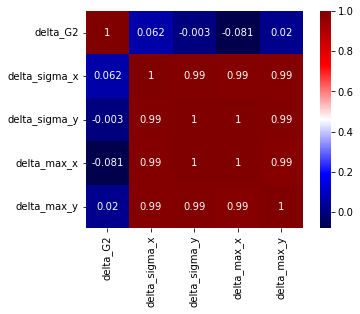

          delta_sigma_x  delta_sigma_y  delta_max_x  delta_max_y
delta_G2       0.061791      -0.002956    -0.080565     0.019761


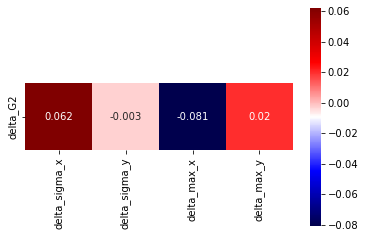

In [79]:
corr_map = delta_log_Q2.corr().iloc[[1,3,4,5,6],[1,3,4,5,6]]
print(corr_map)
plt.figure()
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)
plt.show()

corr_map = delta_log_Q2.corr().iloc[1:2,[3,4,5,6]]
print(corr_map)
plt.figure()
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)
plt.show()

(array([4.00000e+00, 8.00000e+00, 8.00000e+00, 1.10000e+01, 2.30000e+01,
        1.30000e+01, 2.20000e+01, 2.50000e+01, 2.80000e+01, 4.50000e+01,
        8.80000e+01, 1.18000e+02, 2.51000e+02, 5.41000e+02, 4.59900e+03,
        1.16297e+05, 1.42800e+03, 4.04000e+02, 1.85000e+02, 1.10000e+02,
        8.10000e+01, 4.80000e+01, 3.70000e+01, 3.00000e+01, 2.20000e+01,
        1.50000e+01, 1.40000e+01, 1.30000e+01, 1.20000e+01, 1.20000e+01]),
 array([-4.83972279, -4.51231327, -4.18490375, -3.85749423, -3.53008472,
        -3.2026752 , -2.87526568, -2.54785616, -2.22044664, -1.89303713,
        -1.56562761, -1.23821809, -0.91080857, -0.58339905, -0.25598954,
         0.07141998,  0.3988295 ,  0.72623902,  1.05364854,  1.38105806,
         1.70846757,  2.03587709,  2.36328661,  2.69069613,  3.01810565,
         3.34551516,  3.67292468,  4.0003342 ,  4.32774372,  4.65515324,
         4.98256275]),
 <BarContainer object of 30 artists>)

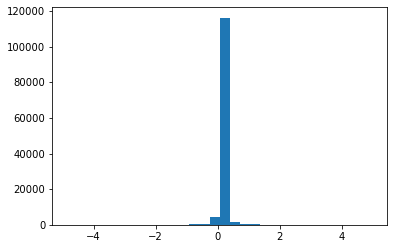

In [92]:
# x y 长宽比变化
xy_ratio = delta_log_Q2['delta_sigma_x'].values/delta_log_Q2['delta_sigma_y'].values
xy_ratio = xy_ratio[(xy_ratio>-5) & (xy_ratio<5)]
plt.hist(xy_ratio, bins=30)

## Q3:

In [52]:
data_log = pd.DataFrame(columns=["G1", "G2", "G3", "sigma_x", "sigma_y", "max_x", "max_y", "good_number"])

rand_delta_G = (np.random.rand(500) - 0.5)*2
for i in trange(len(rand_delta_G)):
    deltaG_and_simulate(0, 0, rand_delta_G[i])

data_log.to_csv("./期末大作业/只调整Q3.csv")

delta_log = pd.DataFrame(columns=["delta_G1", "delta_G2", "delta_G3", "delta_sigma_x", "delta_sigma_y", "delta_max_x", "delta_max_y", "delta_good_number"])
for i in trange(1, len(data_log)):
    for j in range(i):
        delta_log.loc[len(delta_log)] = data_log.loc[i].values - data_log.loc[j].values
delta_log_Q3 = delta_log
delta_log.head(10)

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [06:12<00:00,  1.34it/s]


,delta_G1,delta_G2,delta_G3,delta_sigma_x,delta_sigma_y,delta_max_x,delta_max_y,delta_good_number
0,0.0,0.0,0.412439,-0.003135,-0.002032,-0.008437,-0.005497,0.0
1,0.0,0.0,1.404375,0.001621,0.000644,0.003369,0.003459,0.0
2,0.0,0.0,0.991937,0.004756,0.002675,0.011806,0.008956,0.0
3,0.0,0.0,0.965346,-0.001684,-0.001544,-0.005522,-0.002514,0.0
4,0.0,0.0,0.552908,0.001452,0.000488,0.002915,0.002984,0.0
5,0.0,0.0,-0.439029,-0.003305,-0.002187,-0.008891,-0.005972,0.0
6,0.0,0.0,0.637189,-0.004159,-0.003062,-0.012011,-0.006959,0.0
7,0.0,0.0,0.224751,-0.001024,-0.001031,-0.003574,-0.001462,0.0
8,0.0,0.0,-0.767186,-0.005780,-0.003706,-0.015381,-0.010418,0.0
9,0.0,0.0,-0.328157,-0.002475,-0.001519,-0.006490,-0.004445,0.0


               delta_G3  delta_sigma_x  delta_sigma_y  delta_max_x  \
delta_G3       1.000000       0.009493      -0.122402    -0.066600   
delta_sigma_x  0.009493       1.000000       0.987952     0.996304   
delta_sigma_y -0.122402       0.987952       1.000000     0.997523   
delta_max_x   -0.066600       0.996304       0.997523     1.000000   
delta_max_y    0.074305       0.997648       0.976256     0.988588   

               delta_max_y  
delta_G3          0.074305  
delta_sigma_x     0.997648  
delta_sigma_y     0.976256  
delta_max_x       0.988588  
delta_max_y       1.000000  


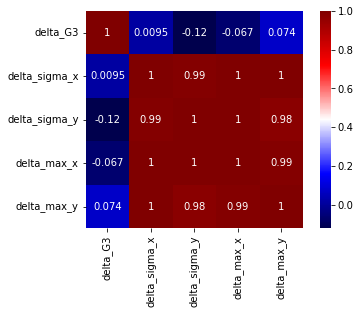

          delta_sigma_x  delta_sigma_y  delta_max_x  delta_max_y
delta_G3       0.009493      -0.122402      -0.0666     0.074305


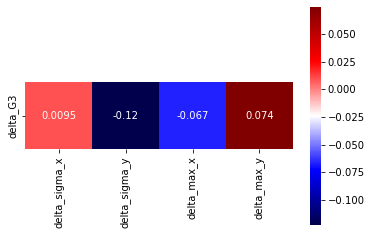

In [78]:
corr_map = delta_log_Q3.corr().iloc[[2,3,4,5,6],[2,3,4,5,6]]
print(corr_map)
plt.figure()
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)
plt.show()

corr_map = delta_log_Q3.corr().iloc[2:3,[3,4,5,6]]
print(corr_map)
plt.figure()
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)
plt.show()

(array([   77.,    80.,   106.,    85.,   105.,   155.,   167.,   188.,
          198.,   274.,   318.,   380.,   481.,   674.,   991.,  1502.,
         2486.,  5361., 16387., 65918., 12718.,  5485.,  2579.,  1408.,
          951.,   693.,   501.,   349.,   299.,   243.]),
 array([-4.99490943e+00, -4.66179856e+00, -4.32868769e+00, -3.99557682e+00,
        -3.66246595e+00, -3.32935508e+00, -2.99624421e+00, -2.66313334e+00,
        -2.33002247e+00, -1.99691160e+00, -1.66380074e+00, -1.33068987e+00,
        -9.97578997e-01, -6.64468128e-01, -3.31357259e-01,  1.75360999e-03,
         3.34864479e-01,  6.67975348e-01,  1.00108622e+00,  1.33419709e+00,
         1.66730796e+00,  2.00041882e+00,  2.33352969e+00,  2.66664056e+00,
         2.99975143e+00,  3.33286230e+00,  3.66597317e+00,  3.99908404e+00,
         4.33219491e+00,  4.66530578e+00,  4.99841665e+00]),
 <BarContainer object of 30 artists>)

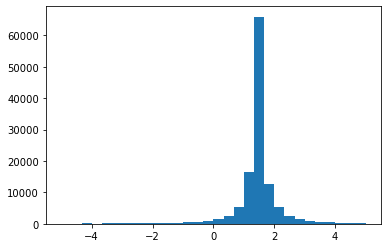

In [93]:
# x y 长宽比变化
xy_ratio = delta_log_Q3['delta_sigma_x'].values/delta_log_Q3['delta_sigma_y'].values
xy_ratio = xy_ratio[(xy_ratio>-5) & (xy_ratio<5)]
plt.hist(xy_ratio, bins=30)

# 3. 尝试决策树分析

In [108]:
from sklearn import tree#导入模块
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [170]:
delta_log_all

,G1,G2,G3,sigma_x,sigma_y,max_x,max_y,good_number,delta_G1,delta_G2,delta_G3,delta_sigma_x,delta_sigma_y,delta_max_x,delta_max_y,delta_good_number
0,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0,0.168567,-0.469236,0.115810,-0.000730,-0.009460,-0.002015,-0.025778,0.0
1,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0,-0.064533,-0.131367,0.294993,0.001698,-0.001600,0.004542,-0.004357,0.0
2,12.932603,-10.425393,12.320510,0.001431,0.000332,0.003326,0.001699,10240.0,-0.233100,0.337869,0.179183,0.002428,0.007860,0.006557,0.021422,0.0
3,12.764036,-9.956157,12.204700,0.002162,0.009792,0.005341,0.027478,10240.0,0.300114,-0.821547,-0.354773,0.001280,-0.000431,0.004473,-0.002827,0.0
4,12.932603,-10.425393,12.320510,0.001431,0.000332,0.003326,0.001699,10240.0,0.131547,-0.352311,-0.470584,0.002011,0.009028,0.006487,0.022952,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124745,13.132273,-10.743826,11.951203,0.002440,0.008002,0.007105,0.020941,10240.0,-0.419175,0.308051,-0.110225,0.000104,-0.005211,0.000286,-0.014147,0.0
124746,13.424120,-10.437393,11.692254,0.002862,0.001860,0.008161,0.004187,10240.0,-0.711022,0.001618,0.148723,-0.000318,0.000931,-0.000770,0.002607,0.0
124747,13.082035,-10.824425,12.563826,0.001963,0.007046,0.004715,0.018329,10240.0,-0.368937,0.388650,-0.722848,0.000581,-0.004256,0.002675,-0.011534,0.0
124748,12.706278,-10.883317,12.427526,0.000356,0.009829,0.000609,0.025947,10240.0,0.006820,0.447542,-0.586549,0.002188,-0.007038,0.006781,-0.019153,0.0


In [167]:
# 测试集比例
test_ratio = 0.8

x = delta_log_all[['G1', 'G2', 'G3', 'sigma_x', 'sigma_y', 'max_x', 'max_y', 'good_number', 'delta_sigma_x', 'delta_sigma_y']]
y = np.array(delta_log_all['delta_G1'].values)
y[y>=0] = 1
y[y<0] = 0
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = test_ratio)

In [174]:
tree1 = tree.DecisionTreeClassifier(max_depth=3)#实例化
tree1 = tree1.fit(x_train,y_train)#用训练集数据训练模型
y_pred = tree1.predict(x_test)#
score = accuracy_score(y_pred, y_test)
print(score)

0.7413627254509018


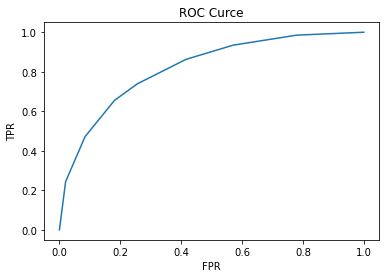

The value of AUC is: 0.8187154135748123


In [175]:
y_pred_proba = tree1.predict_proba(x_test)
y_pred_proba[:10]
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.title("ROC Curce")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

score = roc_auc_score(y_test, y_pred_proba[:,1])
print("The value of AUC is:", score)

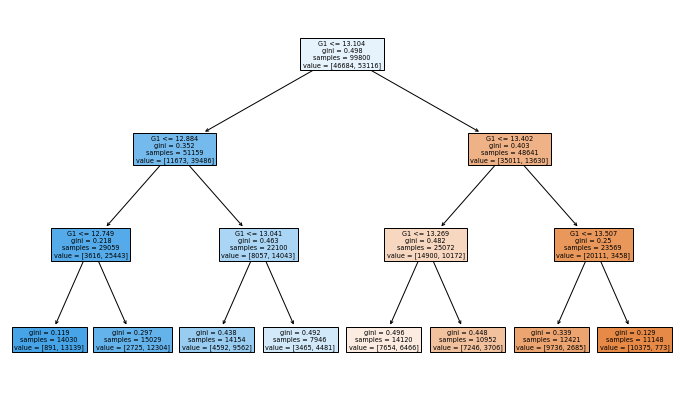

In [176]:
plt.figure(figsize=[12,7])
plot_tree(tree1, feature_names=x_train.columns.to_list(), filled=True)
plt.show()

# 4. 尝试多元线性拟合

In [177]:
from sklearn.linear_model import LinearRegression

In [190]:
# 测试集比例
test_ratio = 0.8

x = delta_log_all[['G1', 'G2', 'G3', 'sigma_x', 'sigma_y', 'max_x', 'max_y', 'good_number', 'delta_sigma_x', 'delta_sigma_y']]
y = delta_log_all[['delta_G1', "delta_G2", "delta_G3"]]
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = test_ratio)

In [198]:
model1 = LinearRegression()
model1.fit(x_train, y_train['delta_G1'])
score = model1.score(x_test,y_test['delta_G1'])
print(score)

model2 = LinearRegression()
model2.fit(x_train, y_train['delta_G2'])
score = model2.score(x_test,y_test['delta_G2'])
print(score)

model3 = LinearRegression()
model3.fit(x_train, y_train['delta_G3'])
score = model3.score(x_test,y_test['delta_G3'])
print(score)

0.4952936299171026
0.4935983970810711
0.49533573889360016


In [201]:
print(model1.coef_)
print(model2.coef_)
print(model3.coef_)

[-1.00080763e+00 -8.91775029e-03 -9.40615206e-03  8.80239922e+00
  1.52321847e+00 -2.58377426e+00  2.04934867e+00 -4.44089210e-15
  2.50390073e+00  6.95399467e+00]
[-1.77556413e-03 -9.96492782e-01 -4.64593169e-04  1.40547038e+01
 -9.76428827e+00 -4.15977070e-02 -1.28125890e+00 -3.55271368e-15
  1.41834291e+01 -1.31686301e+01]
[ 1.24382645e-03 -2.42118746e-03 -1.00193737e+00 -1.38567699e+01
 -1.93524087e+00  9.15319566e-02  1.75335461e+00  5.32907052e-15
 -1.35052312e+01  2.78819153e+00]


In [199]:
y_pred1 = model1.predict(x_test)
print("调整Q1方向正确比例：", np.count_nonzero(y_pred1 * np.array(y_test['delta_G1']) > 0)/len(y_pred1) )
y_pred2 = model2.predict(x_test)
print("调整Q2方向正确比例：", np.count_nonzero(y_pred2 * np.array(y_test['delta_G2']) > 0)/len(y_pred2) )
y_pred3 = model3.predict(x_test)
print("调整Q3方向正确比例：", np.count_nonzero(y_pred3 * np.array(y_test['delta_G3']) > 0)/len(y_pred3) )

调整Q1方向正确比例： 0.7492585170340681
调整Q2方向正确比例： 0.7460120240480962
调整Q3方向正确比例： 0.7402004008016032


In [206]:
loss1 = ((y_pred1 - np.array(y_test['delta_G1']))**2).mean()
loss2 = ((y_pred2 - np.array(y_test['delta_G2']))**2).mean()
loss3 = ((y_pred3 - np.array(y_test['delta_G3']))**2).mean()
print(loss1)
print(loss2)
print(loss3)

0.08981499032956218
0.0827789698367453
0.08480378039303382


# 5. 神经网络拟合，引入非线性

In [211]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
# from torchvision import datasets, transforms

# 将数据集转为torch dataset格式，并划分 训练集、测试集、验证集

In [349]:
#以torch.utils.data.Dataset为基类创建MyDataset
class MyDataset(Dataset):
    #stpe1:初始化
    def __init__(self, x, y):
        self.x = torch.tensor(data=x.values, dtype=torch.float32)
        self.y = torch.tensor(data=y.values, dtype=torch.float32)
 
    def __getitem__(self, index):#检索函数
        data = self.x[index]
        label = self.y[index]
        return data,label
 
    def __len__(self):
        return len(self.y)

x = delta_log_all[['G1', 'G2', 'G3', 'sigma_x', 'sigma_y', 'max_x', 'max_y', 'good_number', 'delta_sigma_x', 'delta_sigma_y']]
y = delta_log_all[['delta_G1', "delta_G2", "delta_G3"]]
mydataset = MyDataset(x, y)

train_size = int(0.7 * len(mydataset))
test_size = int(0.2 * len(mydataset))
validation_size = len(mydataset) - train_size - test_size
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size, validation_size])

In [392]:
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(10, 200), nn.BatchNorm1d(200), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(200, 200), nn.BatchNorm1d(200), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(200, 3))
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [393]:
# 定义一些超参数
batch_size = 256
learning_rate = 0.0001
num_epoches = 2


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

In [385]:
def test_while_train(model, test_loader):
    model.eval()
    loss_list = []
    with torch.no_grad():
        for x,y in test_loader:
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            else:
                x = Variable(x)
                y = Variable(y)
            out = model(x)
            loss = criterion(out, y)
            loss_list.append(loss.cpu().numpy())
    model.train()
    return np.mean(loss_list)

In [386]:
nn_model = FC_Net()
if torch.cuda.is_available():
    nn_model = nn_model.cuda()
    
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

# 训练模型
train_loss = []
test_loss = []
step = 0
for epoch in range(num_epoches):
    for data in train_loader:
        x, y = data
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        else:
            x = Variable(x)
            y = Variable(y)
        out = nn_model(x)
        loss = criterion(out, y)
        print_loss = loss.data.item()
        train_loss.append([step, print_loss])
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step%10 == 9:
            print('epoch: {}, step: {}, loss: {:.4}'.format(epoch, step, loss.data.item()))
            test_loss.append([step, test_while_train(nn_model, test_loader)])
            
        step += 1

train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

epoch: 0, step: 9, loss: 0.1612
epoch: 0, step: 19, loss: 0.1244
epoch: 0, step: 29, loss: 0.1036
epoch: 0, step: 39, loss: 0.09234
epoch: 0, step: 49, loss: 0.08681
epoch: 0, step: 59, loss: 0.08667
epoch: 0, step: 69, loss: 0.09171
epoch: 0, step: 79, loss: 0.08601
epoch: 0, step: 89, loss: 0.0888
epoch: 0, step: 99, loss: 0.09092
epoch: 0, step: 109, loss: 0.08636
epoch: 0, step: 119, loss: 0.0919
epoch: 0, step: 129, loss: 0.08857
epoch: 0, step: 139, loss: 0.08837
epoch: 0, step: 149, loss: 0.08839
epoch: 0, step: 159, loss: 0.08897
epoch: 0, step: 169, loss: 0.09075
epoch: 0, step: 179, loss: 0.08846
epoch: 0, step: 189, loss: 0.09038
epoch: 0, step: 199, loss: 0.08772
epoch: 0, step: 209, loss: 0.0864
epoch: 0, step: 219, loss: 0.09041
epoch: 0, step: 229, loss: 0.08456
epoch: 0, step: 239, loss: 0.08073
epoch: 0, step: 249, loss: 0.08389
epoch: 0, step: 259, loss: 0.0873
epoch: 0, step: 269, loss: 0.0919
epoch: 0, step: 279, loss: 0.09227
epoch: 0, step: 289, loss: 0.08915
epoc

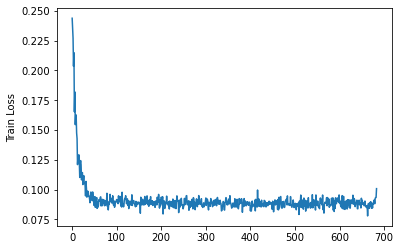

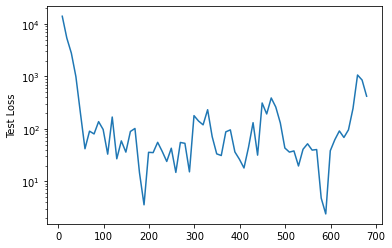

In [387]:
plt.plot(train_loss[:,0], train_loss[:,1])
plt.ylabel("Train Loss")
plt.figure()
plt.semilogy(test_loss[:,0], test_loss[:,1])
plt.ylabel("Test Loss")
plt.show()

In [395]:
def eval_with_dataloader(dataloader):
    y_pred = np.array([])
    y_validation = np.array([])
    with torch.no_grad():
        for x,y in dataloader:
            if len(y_pred)==0:
                y_pred = nn_model(x.cuda()).cpu().numpy()
                y_validation = y.numpy()
            else:
                y_pred = np.concatenate([y_pred, nn_model(x.cuda()).cpu().numpy()], axis = 0)
                y_validation = np.concatenate([y_validation, y], axis = 0)
#     print(y_validation)
#     print(y_pred)
    print("Q1调整方向准确率：",np.count_nonzero(y_pred[:,0]*y_validation[:,0] > 0)/y_validation.shape[0])
    print("Q2调整方向准确率：",np.count_nonzero(y_pred[:,1]*y_validation[:,1] > 0)/y_validation.shape[0])
    print("Q3调整方向准确率：",np.count_nonzero(y_pred[:,2]*y_validation[:,2] > 0)/y_validation.shape[0])

In [396]:
eval_with_dataloader(validation_loader)

[[ 0.1823408  -0.3343486   0.04423449]
 [ 0.6513666  -0.6010226  -0.8462591 ]
 [-0.00185844 -0.48417684 -0.36444739]
 ...
 [ 0.0699784   0.27153984  0.60109717]
 [ 0.5396071  -0.23769617  0.6816078 ]
 [-0.4586417   0.10122426  0.09128541]]
[[ 0.37192175 -0.5373115  -0.31210464]
 [ 0.4997352  -0.2446984  -0.42284602]
 [-0.11878373 -0.28249034 -0.17346786]
 ...
 [-0.22999561 -0.15750197  0.21013112]
 [ 0.06118626 -0.15212852  0.31938228]
 [-0.21496776  0.2785137  -0.39779577]]
Q1调整方向准确率： 0.7383567134268537
Q2调整方向准确率： 0.7353907815631262
Q3调整方向准确率： 0.7438076152304609


# 6. 制作数据集：不同参数统计束腰位置

In [19]:
import pandas as pd
from tqdm import tqdm, trange


0.0030002593994140625 s
0.4647817611694336 s


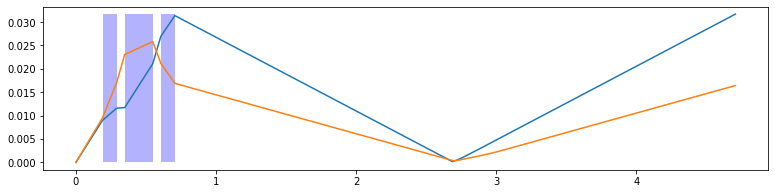

In [4]:
num_particle = 1024

simulator = pyBeamSim.BeamSimulator()
# simulator.free_beam()
simulator.init_beam(num_particle, 939.294, 1.0, 0.015)
start = time.time()
simulator.set_beamTwiss(0, 0.01, 0.00003,0, 0.01, 0.00003,0, 6.5430429, 0.0000005, 0, 4.622, 500, 1)
simulator.save_initial_beam()
# simulator.plot_beam()
# simulator.beam_print_to_file("./beam_file/init_beam")
print(time.time()-start ,'s')
simulator.load_Beamline_From_DatFile("F:/git_workspace/Multi-Particle-BeamLine-Simulation/Main_for_simulation/clapa1_find_waist.dat")
element_names = simulator.get_Beamline_ElementNames()
start = time.time()

# simulator.set_magnet_with_name("Q1", 13.1313463)
# simulator.set_magnet_with_name("Q2", -10.4256375)
# simulator.set_magnet_with_name("Q3", 12.12751015)

envelope = simulator.simulate_and_getEnvelope(False, False)
print(time.time()-start, 's')
simulator.plot_envelope(envelope)

In [11]:
drift = envelope[6:,:]
ind = np.argmin(drift[:,1])
drift[ind]

array([2.68600000e+00, 1.73865147e-04, 3.98445177e-04, 0.00000000e+00])

In [43]:
def deltaG_simulate_get_Waist(delta_G1, delta_G2, delta_G3):
    global data_log
    simulator.set_magnet_with_name("Q1", 13.1313463+delta_G1)
    simulator.set_magnet_with_name("Q2", -10.4256375+delta_G2)
    simulator.set_magnet_with_name("Q3", 12.12751015+delta_G3)
#     simulator.set_beamTwiss(0, 0.01, 0.000015,0, 0.01, 0.000015,0, 6.5430429, 0.0005633529, 0, 3, 500, 1)
    simulator.restore_initial_beam()
#     envelope = simulator.simulate_all(False, False)
#     simulator.simulate_all(False, False)
    envelope = simulator.simulate_and_getEnvelope(False, False)
    drift_envelope = envelope[6:,:]
    
    ind_x = np.argmin(drift_envelope[:,1])
    ind_y = np.argmin(drift_envelope[:,2])
    if(ind_x == 0 or ind_x == len(drift_envelope)-1):
        waist_x = np.nan
        return
    else:
        waist_x = drift_envelope[ind_x, 0]
    
    if(ind_y == 0 or ind_y == len(drift_envelope)-1):
        waist_y = np.nan
        return 
    else:
        waist_y = drift_envelope[ind_y, 0]
#     delta_sigma_x = simulator.getBeamSigx()
#     delta_sigma_y = simulator.getBeamSigy()
#     delta_max_x = simulator.getBeamMaxx()
#     delta_max_y = simulator.getBeamMaxy()
#     delta_good_num = simulator.get_good_num()
    data_log.loc[len(data_log)] = [13.1313463+delta_G1, -10.4256375+delta_G2, 12.12751015+delta_G3, waist_x, waist_y]

# 同时随机调整3个磁铁

In [44]:
data_log = pd.DataFrame(columns=["G1", "G2", "G3", "waist_x", "waist_y"])

rand_delta_G = (np.random.rand(1000,3) - 0.5)*2
for i in trange(len(rand_delta_G)):
    deltaG_simulate_get_Waist(rand_delta_G[i,0], rand_delta_G[i,1], rand_delta_G[i,2])

delta_log = pd.DataFrame(columns=["G1", "G2", "G3", "waist_x", "waist_y", "delta_G1", "delta_G2", "delta_G3", "delta_waist_x", "delta_waist_y"])
for i in trange(1, len(data_log)):
    for j in range(i):
        delta_log.loc[len(delta_log)] = np.append(data_log.loc[j].values, data_log.loc[i].values - data_log.loc[j].values)
delta_log_all = delta_log
delta_log_all.to_csv("./期末大作业/束腰数据集_调整3块磁铁.csv")
delta_log.head(10)

100%|█████████████████████████████████████████████████████████████████████████████| 495/495 [07:03<00:00,  1.17it/s]


,G1,G2,G3,waist_x,waist_y,delta_G1,delta_G2,delta_G3,delta_waist_x,delta_waist_y
0,13.554944,-11.301051,11.731830,4.286,1.116,-1.020622,0.760866,0.091799,-0.92,0.64
1,13.554944,-11.301051,11.731830,4.286,1.116,-1.376244,0.309397,0.521301,-1.24,0.13
2,12.534322,-10.540185,11.823630,3.366,1.756,-0.355622,-0.451469,0.429502,-0.32,-0.51
3,13.554944,-11.301051,11.731830,4.286,1.116,-0.869776,0.410940,-0.176262,0.35,0.16
4,12.534322,-10.540185,11.823630,3.366,1.756,0.150846,-0.349926,-0.268061,1.27,-0.48
5,12.178700,-10.991654,12.253131,3.046,1.246,0.506468,0.101543,-0.697563,1.59,0.03
6,13.554944,-11.301051,11.731830,4.286,1.116,0.183177,0.101599,0.644812,-1.54,0.13
7,12.534322,-10.540185,11.823630,3.366,1.756,1.203799,-0.659267,0.553013,-0.62,-0.51
8,12.178700,-10.991654,12.253131,3.046,1.246,1.559421,-0.207798,0.123511,-0.30,0.00
9,12.685169,-10.890112,11.555569,4.636,1.276,1.052952,-0.309341,0.821074,-1.89,-0.03


                     G1        G2        G3   waist_x   waist_y  delta_G1  \
delta_waist_x -0.084845 -0.027225  0.630849 -0.694852  0.106590  0.095297   
delta_waist_y -0.018653 -0.600431  0.082217  0.109861 -0.716074  0.051516   

               delta_G2  delta_G3  
delta_waist_x  0.037774 -0.908698  
delta_waist_y  0.838475 -0.112864  


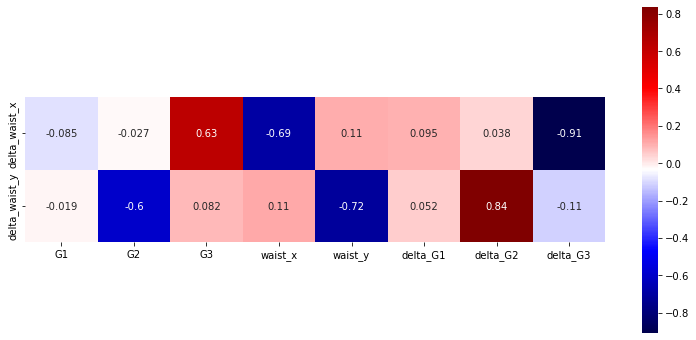

In [47]:
corr_map = delta_log_all.corr().iloc[-2:,:-2]
print(corr_map)
plt.figure(figsize=[13,6])
sns.heatmap(data=corr_map, square=True, cmap="seismic", annot=True)
plt.show()

# 6.1 对上述数据集，尝试多元线性回归¶

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

* 回归x方向束腰位置

In [89]:
test_ratio = 0.8

delta_log_all.isna()
x = delta_log_all[['G1', 'G2', 'G3', "waist_x", "waist_y", "delta_G1", "delta_G2", "delta_G3",]]
y = delta_log_all["delta_waist_x"]
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = test_ratio)

In [90]:
LR_x = LinearRegression()
LR_x.fit(x_train, y_train)
y_pred = LR_x.predict(x_test)
print("MSE:", mse)
r2 = r2_score(y_pred, y_test)
print("R2 Square:", r2)

MSE: 0.13498083525304244
R2 Square: 0.9599318286348283


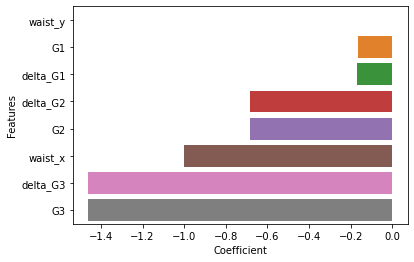

In [91]:
features_coef = pd.DataFrame()
features_coef['Features'] = x_train.columns
features_coef['Coefficient'] = LR_x.coef_
features_coef = features_coef.sort_values('Coefficient', ascending=False)
sns.barplot(data=features_coef, x="Coefficient", y="Features",orient='h')
plt.show()

* 回归y方向束腰位置

In [92]:
test_ratio = 0.8

delta_log_all.isna()
x = delta_log_all[['G1', 'G2', 'G3', "waist_x", "waist_y", "delta_G1", "delta_G2", "delta_G3",]]
y = delta_log_all["delta_waist_y"]
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = test_ratio)

In [93]:
LR_y = LinearRegression()
LR_y.fit(x_train, y_train)
y_pred = LR_y.predict(x_test)
print("MSE:", mse)
r2 = r2_score(y_pred, y_test)
print("R2 Square:", r2)

MSE: 0.13498083525304244
R2 Square: 0.8679338371469443


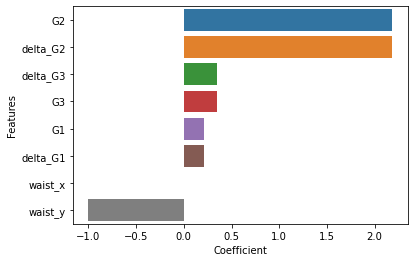

In [94]:
features_coef = pd.DataFrame()
features_coef['Features'] = x_train.columns
features_coef['Coefficient'] = LR_y.coef_
features_coef = features_coef.sort_values('Coefficient', ascending=False)
sns.barplot(data=features_coef, x="Coefficient", y="Features",orient='h')
plt.show()

# 6.2 对上述数据集，用决策树做非线性回归

In [50]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

* 回归x方向束腰位置

In [42]:
len(delta_log_all)

124750

In [41]:
delta_log_all[delta_log_all.isnull().T.any()]

,G1,G2,G3,waist_x,waist_y,delta_G1,delta_G2,delta_G3,delta_waist_x,delta_waist_y
0,13.746461,-9.938518,12.722723,1.976,NaN,0.031331,0.485984,-0.581572,0.18,NaN
1,13.746461,-9.938518,12.722723,1.976,NaN,-0.770710,0.218524,-1.519899,1.73,NaN
2,13.777792,-9.452535,12.141151,2.156,NaN,-0.802041,-0.267460,-0.938328,1.55,NaN
3,13.746461,-9.938518,12.722723,1.976,NaN,-1.126015,0.497410,0.153767,-0.11,NaN
4,13.777792,-9.452535,12.141151,2.156,NaN,-1.157346,0.011426,0.735339,-0.29,NaN
...,...,...,...,...,...,...,...,...,...,...
124745,13.662163,-10.604683,11.449974,4.046,1.726,0.078397,0.070218,1.567547,-2.06,NaN
124746,12.914457,-10.326538,12.099884,2.696,3.296,0.826103,-0.207926,0.917637,-0.71,NaN
124747,12.340573,-9.438373,12.279763,2.196,NaN,1.399988,-1.096092,0.737758,-0.21,NaN
124748,12.192002,-10.232223,11.357988,4.376,2.246,1.548559,-0.302241,1.659533,-2.39,NaN


* 回归x方向束腰位置

In [102]:
test_ratio = 0.8

delta_log_all.isna()
x = delta_log_all[['G1', 'G2', 'G3', "waist_x", "waist_y", "delta_G1", "delta_G2", "delta_G3",]]
y = delta_log_all["delta_waist_x"]
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = test_ratio)

In [103]:
tree_x = DecisionTreeRegressor()
tree_x.fit(x_train, y_train)
y_pred = tree_x.predict(x_test)
mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)
r2 = r2_score(y_pred, y_test)
print("R2 Square:", r2)

MSE: 0.012897992016943081
R2 Square: 0.9879118580735999


In [70]:
features = x_test.columns  
importances = tree_x.feature_importances_
features_importances = pd.DataFrame()
features_importances['Features'] = features
features_importances['Importances'] = importances
features_importances = features_importances.sort_values('Importances', ascending=False)
features_importances

,Features,Importances
7,delta_G3,0.826722
6,delta_G2,0.077345
3,waist_x,0.060141
5,delta_G1,0.019698
2,G3,0.013990
1,G2,0.001047
0,G1,0.000558
4,waist_y,0.000500


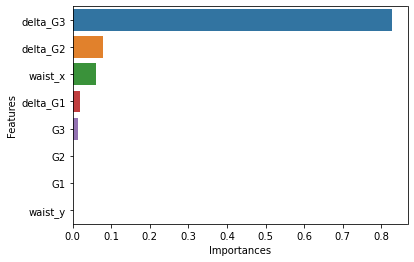

In [71]:
sns.barplot(data=features_importances, x="Importances", y="Features",orient='h')
plt.show()

MSE: 0.13498083525304244
R2 Square: 0.8558886002180437


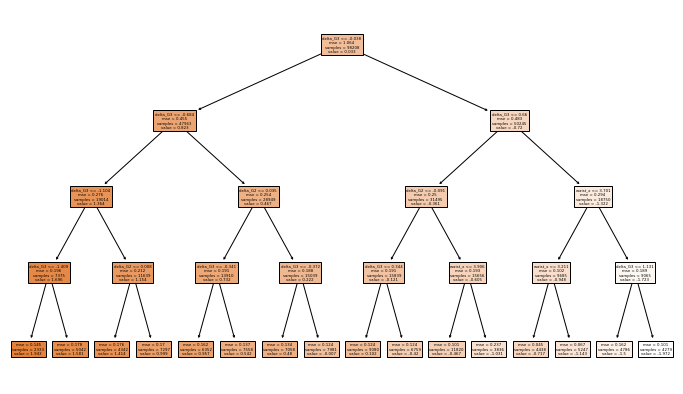

In [78]:
tree_x = DecisionTreeRegressor(max_depth=4)
tree_x.fit(x_train, y_train)
y_pred = tree_x.predict(x_test)
mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)
r2 = r2_score(y_pred, y_test)
print("R2 Square:", r2)

plt.figure(figsize=[12,7])
plot_tree(tree_x, feature_names=x_train.columns.to_list(), filled=True)
plt.savefig("./期末大作业/Tree_x_waist.png", dpi=200)
plt.show()

* 回归y方向束腰位置

In [97]:
test_ratio = 0.8

delta_log_all.isna()
x = delta_log_all[['G1', 'G2', 'G3', "waist_x", "waist_y", "delta_G1", "delta_G2", "delta_G3"]]
y = delta_log_all["delta_waist_y"]
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = test_ratio)

In [98]:
tree_y = DecisionTreeRegressor()
tree_y.fit(x_train, y_train)
y_pred = tree_y.predict(x_test)
mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)
r2 = r2_score(y_pred, y_test)
print("R2 Square:", r2)

MSE: 0.057905461876830426
R2 Square: 0.9567791883296974


In [99]:
features = x_test.columns  
importances = tree_y.feature_importances_
features_importances = pd.DataFrame()
features_importances['Features'] = features
features_importances['Importances'] = importances
features_importances = features_importances.sort_values('Importances', ascending=False)
features_importances

,Features,Importances
6,delta_G2,0.663379
4,waist_y,0.194020
7,delta_G3,0.057337
1,G2,0.046196
5,delta_G1,0.030609
3,waist_x,0.003963
2,G3,0.002628
0,G1,0.001869


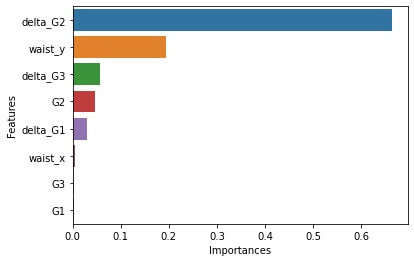

In [100]:
sns.barplot(data=features_importances, x="Importances", y="Features",orient='h')
plt.show()

MSE: 0.24131078614447862
R2 Square: 0.7817842525524562


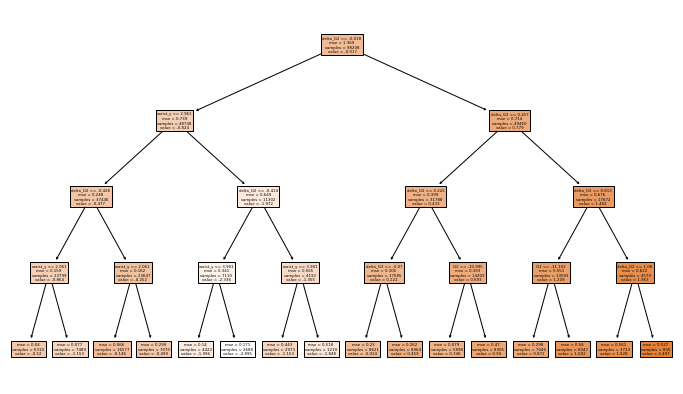

In [101]:
tree_y = DecisionTreeRegressor(max_depth=4)
tree_y.fit(x_train, y_train)
y_pred = tree_y.predict(x_test)
mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)
r2 = r2_score(y_pred, y_test)
print("R2 Square:", r2)

plt.figure(figsize=[12,7])
plot_tree(tree_y, feature_names=x_train.columns.to_list(), filled=True)
plt.savefig("./期末大作业/Tree_y_waist.png", dpi=200)
plt.show()

# 6.3 使用全连接神经网络，进行非线性回归

In [115]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
# from torchvision import datasets, transforms

# 将数据集转为torch dataset格式，并划分 训练集、测试集、验证集

In [117]:
delta_log_all

,G1,G2,G3,waist_x,waist_y,delta_G1,delta_G2,delta_G3,delta_waist_x,delta_waist_y
0,13.554944,-11.301051,11.731830,4.286,1.116,-1.020622,0.760866,0.091799,-0.92,0.64
1,13.554944,-11.301051,11.731830,4.286,1.116,-1.376244,0.309397,0.521301,-1.24,0.13
2,12.534322,-10.540185,11.823630,3.366,1.756,-0.355622,-0.451469,0.429502,-0.32,-0.51
3,13.554944,-11.301051,11.731830,4.286,1.116,-0.869776,0.410940,-0.176262,0.35,0.16
4,12.534322,-10.540185,11.823630,3.366,1.756,0.150846,-0.349926,-0.268061,1.27,-0.48
...,...,...,...,...,...,...,...,...,...,...
122755,12.933015,-10.360617,11.327538,4.386,2.066,0.608883,-0.618730,1.697143,-2.26,-0.47
122756,13.924610,-11.295002,11.863122,3.716,1.146,-0.382712,0.315655,1.161558,-1.59,0.45
122757,12.672094,-10.810304,13.124098,2.076,1.776,0.869804,-0.169043,-0.099418,0.05,-0.18
122758,13.443389,-10.796380,11.815977,3.406,1.506,0.098510,-0.182968,1.208704,-1.28,0.09


In [118]:
#以torch.utils.data.Dataset为基类创建MyDataset
class MyDataset(Dataset):
    #stpe1:初始化
    def __init__(self, x, y):
        self.x = torch.tensor(data=x.values, dtype=torch.float32)
        self.y = torch.tensor(data=y.values, dtype=torch.float32)
 
    def __getitem__(self, index):#检索函数
        data = self.x[index]
        label = self.y[index]
        return data,label
 
    def __len__(self):
        return len(self.y)

x = delta_log_all[['G1', 'G2', 'G3', "waist_x", "waist_y", "delta_G1", "delta_G2", "delta_G3"]]
y = delta_log_all[['delta_waist_x',"delta_waist_y"]]
mydataset = MyDataset(x, y)

train_size = int(0.7 * len(mydataset))
test_size = int(0.2 * len(mydataset))
validation_size = len(mydataset) - train_size - test_size
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size, validation_size])

In [119]:
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(8, 200), nn.BatchNorm1d(200), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(200, 200), nn.BatchNorm1d(200), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(200, 2))
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [120]:
# 定义一些超参数
batch_size = 256
learning_rate = 0.001
num_epoches = 2


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

In [121]:
def test_while_train(model, test_loader):
    model.eval()
    loss_list = []
    with torch.no_grad():
        for x,y in test_loader:
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            else:
                x = Variable(x)
                y = Variable(y)
            out = model(x)
            loss = criterion(out, y)
            loss_list.append(loss.cpu().numpy())
    model.train()
    return np.mean(loss_list)

In [122]:
nn_model = FC_Net()
if torch.cuda.is_available():
    nn_model = nn_model.cuda()
    
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

# 训练模型
train_loss = []
test_loss = []
step = 0
for epoch in range(num_epoches):
    for data in train_loader:
        x, y = data
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        else:
            x = Variable(x)
            y = Variable(y)
        out = nn_model(x)
        loss = criterion(out, y)
        print_loss = loss.data.item()
        train_loss.append([step, print_loss])
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step%10 == 9:
            print('epoch: {}, step: {}, loss: {:.4}'.format(epoch, step, loss.data.item()))
            test_loss.append([step, test_while_train(nn_model, test_loader)])
            
        step += 1

train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

epoch: 0, step: 9, loss: 0.2314
epoch: 0, step: 19, loss: 0.1232
epoch: 0, step: 29, loss: 0.1246
epoch: 0, step: 39, loss: 0.07053
epoch: 0, step: 49, loss: 0.05979
epoch: 0, step: 59, loss: 0.06882
epoch: 0, step: 69, loss: 0.05548
epoch: 0, step: 79, loss: 0.05252
epoch: 0, step: 89, loss: 0.02991
epoch: 0, step: 99, loss: 0.03977
epoch: 0, step: 109, loss: 0.04026
epoch: 0, step: 119, loss: 0.03895
epoch: 0, step: 129, loss: 0.04315
epoch: 0, step: 139, loss: 0.03383
epoch: 0, step: 149, loss: 0.03719
epoch: 0, step: 159, loss: 0.02338
epoch: 0, step: 169, loss: 0.02783
epoch: 0, step: 179, loss: 0.02409
epoch: 0, step: 189, loss: 0.0388
epoch: 0, step: 199, loss: 0.02272
epoch: 0, step: 209, loss: 0.0208
epoch: 0, step: 219, loss: 0.02321
epoch: 0, step: 229, loss: 0.02324
epoch: 0, step: 239, loss: 0.03071
epoch: 0, step: 249, loss: 0.01838
epoch: 0, step: 259, loss: 0.04627
epoch: 0, step: 269, loss: 0.03462
epoch: 0, step: 279, loss: 0.03187
epoch: 0, step: 289, loss: 0.02444
e

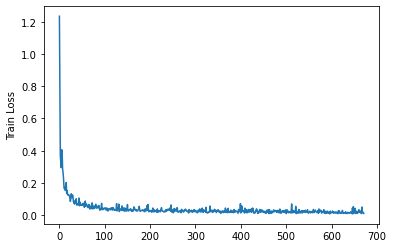

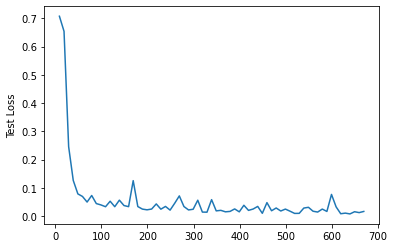

In [124]:
plt.plot(train_loss[:,0], train_loss[:,1])
plt.ylabel("Train Loss")
plt.figure()
plt.plot(test_loss[:,0], test_loss[:,1])
plt.ylabel("Test Loss")
plt.show()

In [127]:
def eval_with_dataloader(dataloader):
    y_pred = np.array([])
    y_real = np.array([])
    with torch.no_grad():
        for x,y in dataloader:
            if len(y_pred)==0:
                y_pred = nn_model(x.cuda()).cpu().numpy()
                y_real = y.numpy()
            else:
                y_pred = np.concatenate([y_pred, nn_model(x.cuda()).cpu().numpy()], axis = 0)
                y_real = np.concatenate([y_real, y], axis = 0)
    return y_pred, y_real

In [128]:
y_pred, y_test = eval_with_dataloader(test_loader)
mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)
r2 = r2_score(y_pred, y_test)
print("R2 Square:", r2)

MSE: 0.012460049
R2 Square: 0.9898352584001409


In [130]:
y_pred, y_validation = eval_with_dataloader(validation_loader)
mse = mean_squared_error(y_pred, y_validation)
print("MSE:", mse)
r2 = r2_score(y_pred, y_validation)
print("R2 Square:", r2)

MSE: 0.012417466
R2 Square: 0.9899684943990905
